# Разработка сверточной нейронной сети с использованием библиотеки PyTorch

In [1]:
import os
from matplotlib import pyplot as plot
import numpy as np
import time

import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn


## 1. Загрузка и визуализация набора данных CIFAR 10

In [2]:
# Загрузка набора данных CIFAR 10

dir_name = os.getcwd() # скачивание данных выполняется в текущую директорию
dir_name += "\\cifar10"
batch_size = 100 # размер обрабатываемой пачки данных

# Чтение тренировочной и тестовой выборок набора данных CIFAR 10.
# Данные представляются в виде пар (tuple), где первый элемент - 
# изображение в формате PIL.Image.Image, а второй - целочисленная
# метка класса.Параметр transform обеспечивает преобразование
# изображений в формат torch.Tensor для последующей работы
# transforms.Normalize используется для нормализации данных 
# путем указания среднего значения и стандартного отклонения для каждого из трех каналов.
# Это преобразует данные из [0,1] в [-1,1]

# Нормализация данных должна помочь ускорить преобразование и
# уменьшить вероятность исчезновения градиентов с определенными
# функции активации.

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
# transform = torchvision.transforms.ToTensor()

train_dataset = torchvision.datasets.CIFAR10(root=dir_name, train=True, download=True,
                                             transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root = dir_name, train = False, download = True,
                                            transform = transform)

# Логирование информации о загруженных данных
print('Number of train samples: {}'.format(len(train_dataset)))

print('Number of test samples: {}'.format(len(test_dataset)))

# Создание объектов для последовательной загрузки пачек
# из тренировочной и тестовой выборок
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size,
                                                shuffle = True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size,
                                               shuffle = False)


Files already downloaded and verified
Files already downloaded and verified
Number of train samples: 50000
Number of test samples: 10000


classes ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
torch.Size([3, 32, 32])
bird


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


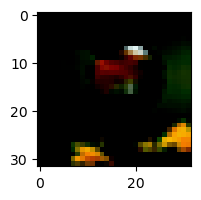

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dog


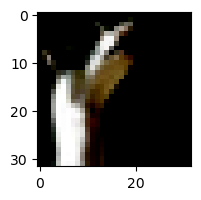

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


airplane


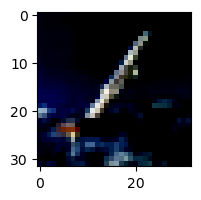

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


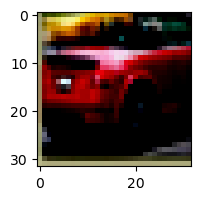

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck


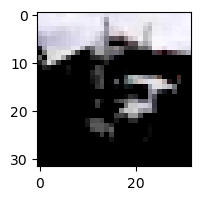

In [3]:
# Визуализация первых 10 изображений
# Получение списка классов
classes = train_dataset.classes
print("classes", classes)

# Функция для демонстрации примеров изображений

def image_show(image_data):
    np_image = image_data.numpy()
    np_image = np.transpose(np_image, (1,2,0))
    plot.figure(figsize = (2,2))
    plot.imshow(np_image)
    plot.show()
    
# Каждый элемент из образца представляет собой кортеж, содержащий тензор изображения и метку.
# Поскольку данные состоят из цветных изображений 32x32 пикселей с 3 каналами (RGB), 
# каждый тензор изображения имеет размерность (3, 32, 32). Проверим.

   
# Выведем на экран первые 10 изображений с метками классов для подтверждения корректности загрузки.    
data_iter = iter(train_data_loader)
images,labels = next(data_iter)
img_data = images[0]
print(img_data.shape)
for i in range(5, 10):
    print(classes[labels[i].item()])
    image_show(images[i])


## 2. Создание, обучение и тестирование модели

In [4]:
# Создание модели, соответствующей логистической регрессии
import torch.nn as nn
# Создание класса сети, соответствующей логистической регрессии
class ConvolutionalNeuralNetwork(torch.nn.Module):
    
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
    # Первый свёрточный слой: 3 канала ввода изображения, 64 канала вывода, 3x3 квадратное сверточное ядро
        self.conv1 = torch.nn.Conv2d(3, 64, 3)
        self.conv2 = torch.nn.Conv2d(64, 128, 3)
        self.conv3 = torch.nn.Conv2d(128, 256, 3)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(64 * 4 * 4, 128)
        self.fc2 = torch.nn.Linear(128, 256)
        self.fc3 = torch.nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = self.pool(torch.nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.nn.functional.log_softmax(x, dim=1)
    
# Создание объекта разработанного класса
cnn_model = ConvolutionalNeuralNetwork()

# Логирование информации о параметрах модели
print(cnn_model)
total = 0
print('Trainable parameters:')
for name, param in cnn_model.named_parameters():
    if param.requires_grad:
        print(name, '\t', param.numel())
        total += param.numel()
print()
print('Total', '\t', total)

ConvolutionalNeuralNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
Trainable parameters:
conv1.weight 	 1728
conv1.bias 	 64
conv2.weight 	 73728
conv2.bias 	 128
conv3.weight 	 294912
conv3.bias 	 256
fc1.weight 	 131072
fc1.bias 	 128
fc2.weight 	 32768
fc2.bias 	 256
fc3.weight 	 2560
fc3.bias 	 10

Total 	 537610


In [5]:
# Обучение построенной модели на CPU

learning_rate = 0.1 # скорость обучения
num_epochs = 10 # количество эпох

# Выбор устройства для вычислений
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)
# Функция ошибки на этапе обучения
loss_function = torch.nn.CrossEntropyLoss()
# Метод оптимизации для обучения параметров
optimizer = torch.optim.SGD(cnn_model.parameters(), lr = learning_rate)

# Функция вычисления точности top-1
def get_accuracy(data_loader, model):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader: # проход по всем данным
            # Получение выхода сети на входной пачке изображений
            outputs = model(images)
            # Выбор предсказанных меток с максимальной достоверностью.
            # outputs.data - объект типа torch.tensor, двумерный тензор, массив
            # векторов достоверности принадлежности каждому из 10 допустимых классов
            # (размерность 0 - номер изображения в пачке, размерность 1 - номер класса);
            # predicted - объект типа torch.tensor (одномерный тензор меток классов).
            # Выбор максимальных значений выполняется по первой размерности
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0) # количество изображений, совпадает с batch_size
            tp += (predicted == labels).sum() # определение количества корректных совпадений
    return tp / n

start_time = time.time()
for epoch in range(num_epochs):  # проход по эпохам
    for i, (images, labels) in enumerate(train_data_loader): # получение пачки тренировочных данных
        # Загрузка данных на устройство
        images = images.requires_grad_().to(device)
        labels = labels.to(device)
        # Прямой проход
        outputs = cnn_model(images) # вычисление выхода сети
        loss = loss_function(outputs, labels) # вычисление функции ошибки, loss.item() дает значение
        # Обратный проход
        optimizer.zero_grad() # обнуление всех вычисляемых градиентов
        loss.backward() # вычисление градиента функции ошибки
        optimizer.step() # обновление параметров модели
    
    # Логирование метрики качества на тренировочных данных по завершении эпохи
    print('Epoch[{}]: accuracy = {}'.
          format(epoch, get_accuracy(train_data_loader, cnn_model)))
  
end_time = time.time()

elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

Epoch[0]: accuracy = 0.39866000413894653
Epoch[1]: accuracy = 0.48561999201774597
Epoch[2]: accuracy = 0.5984799861907959
Epoch[3]: accuracy = 0.6454200148582458
Epoch[4]: accuracy = 0.7069000005722046
Epoch[5]: accuracy = 0.7489200234413147
Epoch[6]: accuracy = 0.7785999774932861
Epoch[7]: accuracy = 0.8104199767112732
Epoch[8]: accuracy = 0.8546000123023987
Epoch[9]: accuracy = 0.7528600096702576
Execution time: 3775.5751905441284 seconds


In [7]:
start_time = time.time()
print('Test accuracy: {}'.format(get_accuracy(test_data_loader, cnn_model)))
end_time = time.time()

elapsed_time = (end_time - start_time) / len(test_dataset)
#  Вывод среднего времени классификации одного изображения
print('Execution time:', elapsed_time, 'seconds ')

Test accuracy: 0.6401000022888184
Execution time: 0.0031305962562561034 seconds 
